In [2]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from scipy.fftpack import fft

import gc
%matplotlib inline

In [3]:
%time
train_df = pd.read_csv(os.path.join("../input",'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


In [4]:
train_df.shape

(629145480, 2)

In [5]:
rows = 150000
segments = int(np.floor(train_df.shape[0] / rows))
print("Number of segments: ", segments)

Number of segments:  4194


In [40]:
train_X = pd.DataFrame(index=range(segments), dtype=np.float64)
train_y = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

In [41]:
def add_statistics(seg_id,feat_name,X,xc,ws=""):
    X.loc[seg_id,feat_name + "_mean"+ws] = xc.mean()
    X.loc[seg_id,feat_name + "_var"+ws] = xc.var()
    X.loc[seg_id,feat_name + "_min"+ws] = xc.min()
    X.loc[seg_id,feat_name + "_max"+ws] = xc.max()
    X.loc[seg_id,feat_name + "_kurt"+ws] = xc.kurt()
    X.loc[seg_id,feat_name + "_skew"+ws] = xc.skew()
    
def create_features(seg_id,seg, X):
    xc = seg["acoustic_data"]
    
    fftxc = fft(xc)
    X.loc[seg_id,"fft_mean"] = np.abs(fftxc).mean()
    X.loc[seg_id,"fft_max"] = np.abs(fftxc).max()
    X.loc[seg_id,"fft_min"] = np.abs(fftxc).min()
    
    X.loc[seg_id,"25_quantile"] = xc.quantile(0.25)
    X.loc[seg_id,"50_quantile"] = xc.quantile(0.50)
    X.loc[seg_id,"75_quantile"] = xc.quantile(0.75)
    X.loc[seg_id,"1_quantile"] = xc.quantile(0.01)
    X.loc[seg_id,"99_quantile"] = xc.quantile(0.99)
#     add_statistics(seg_id,"3_part",X,xc_splitted[2])
#     add_statistics(seg_id,"4_part",X,xc_splitted[3])

    xc_splitted = np.array_split(xc, 4)
    add_statistics(seg_id,"1_part",X,xc_splitted[0])
    add_statistics(seg_id,"2_part",X,xc_splitted[1])
    add_statistics(seg_id,"3_part",X,xc_splitted[2])
    add_statistics(seg_id,"4_part",X,xc_splitted[3])

    X.loc[seg_id,"avg"] = xc.mean()
    X.loc[seg_id,"max"] = xc.max()
    X.loc[seg_id,"min"] = xc.min()
    X.loc[seg_id,"skew"] = xc.skew()
    X.loc[seg_id,"kurt"] = xc.kurt()
    X.loc[seg_id,"var"] = xc.var()
    
#     window_sizes = [20,100,500,1000]
#     for window_size in window_sizes:
#         xc_rolled = xc.rolling(window_size)
#         xc_rolled_mean = xc_rolled.mean().dropna()
#         xc_rolled_var = xc_rolled.var().dropna()
#         ws = str(window_size)
        
#         add_statistics(seg_id,"rollingMean",X,xc_rolled_mean,ws=ws)
#         add_statistics(seg_id,"rollingVar",X,xc_rolled_var,ws=ws)

In [42]:
for seg_id in tqdm_notebook(range(segments)):
    seg = train_df.iloc[seg_id*rows:seg_id*rows+rows]
    create_features(seg_id, seg,train_X)
    train_y.loc[seg_id, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    

In [43]:
def load_test():
    signals = []
    segment_names = [file for file in os.listdir("../input") if file.startswith("seg")]
    test_df = pd.DataFrame(index=segment_names, dtype=np.float64)
    test_df.index = test_df.index.str[:-4]
    for file in tqdm_notebook(segment_names):
        seg_id = file[:-4]
        segment = pd.read_csv(os.path.join("../input",file),dtype={'acoustic_data': np.int16})
        create_features(seg_id,segment,test_df)
    return test_df
test_df = load_test()

In [44]:
train_X.head()

,fft_mean,fft_max,fft_min,25_quantile,50_quantile,75_quantile,1_quantile,99_quantile,1_part_mean,1_part_var,...,4_part_min,4_part_max,4_part_kurt,4_part_skew,avg,max,min,skew,kurt,var
0,1251.532473,732617.0,1.677194,3.0,5.0,7.0,-8.0,18.0,4.999120,49.467105,...,-21.0,30.0,2.210387,0.038588,4.884113,104.0,-98.0,-0.024061,33.662481,26.021284
1,1460.006819,708865.0,2.454891,2.0,5.0,7.0,-11.0,21.0,4.658240,60.043841,...,-115.0,111.0,60.379055,-0.273479,4.725767,181.0,-154.0,0.390561,98.758517,43.412599
2,1516.841892,735959.0,2.389381,2.0,5.0,7.0,-15.0,26.0,4.688747,40.522229,...,-106.0,140.0,25.605753,0.353324,4.906393,140.0,-106.0,0.217391,33.555211,48.544621
3,1494.430080,735336.0,2.524297,2.0,5.0,7.0,-12.0,22.0,4.908080,42.681302,...,-79.0,84.0,30.445738,-0.187664,4.902240,197.0,-199.0,0.757278,116.548172,47.918309
4,1566.780849,736308.0,3.839907,2.0,5.0,7.0,-15.0,26.0,4.897360,31.609695,...,-126.0,128.0,68.808075,-0.456959,4.908720,145.0,-126.0,0.064531,52.977905,53.306210


In [45]:
test_df.head()

,fft_mean,fft_max,fft_min,25_quantile,50_quantile,75_quantile,1_quantile,99_quantile,1_part_mean,1_part_var,...,4_part_min,4_part_max,4_part_kurt,4_part_skew,avg,max,min,skew,kurt,var
seg_90a0be,1612.790928,652327.0,1.978895,2.0,4.0,7.0,-17.0,26.0,4.437840,41.685648,...,-84.0,105.0,26.276541,-0.140739,4.348847,183.0,-180.0,0.176450,71.508607,61.692057
seg_0cb81b,1381.489691,647500.0,1.889502,2.0,4.0,7.0,-12.0,21.0,4.181627,45.449904,...,-77.0,76.0,24.205346,-0.028088,4.316667,117.0,-99.0,0.035662,32.249438,35.618466
seg_264c7d,1122.264076,588939.0,6.470284,2.0,4.0,6.0,-6.0,14.0,3.954293,11.196396,...,-84.0,88.0,50.613799,0.111680,3.926260,88.0,-84.0,0.017205,35.364159,17.009282
seg_b02e31,1117.967296,584524.0,6.510837,2.0,4.0,6.0,-6.0,13.0,3.872933,26.837503,...,-36.0,48.0,15.288407,0.033899,3.896827,80.0,-81.0,-0.045952,36.239618,16.491505
seg_8f25b0,981.870172,596717.0,5.991670,2.0,4.0,6.0,-3.0,11.0,4.157973,13.117368,...,-10.0,18.0,0.433948,-0.015351,3.978113,47.0,-48.0,0.071555,9.005889,10.128929


In [46]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

In [47]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'min_data_in_leaf': 10, 
    'metric': {'l2', 'l1'},
    'num_leaves': 45,
    'max_depth':4,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'metric':'mae'
}

In [48]:
features_importance = pd.DataFrame({"features":train_X.columns,
                                    "importance":np.zeros(train_X.columns.shape[0])})
predictions = pd.DataFrame({"seg_id":test_df.index,"time_to_failure":np.zeros(test_df.shape[0])})
oof = np.zeros(train_X.shape[0])

for train_idx,val_idx in folds.split(train_X,train_y):
    X_train,y_train = train_X.iloc[train_idx],train_y.iloc[train_idx]
    X_val,y_val = train_X.iloc[val_idx],train_y.iloc[val_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train)
    model = lgb.LGBMRegressor(**params, n_estimators = 20000, n_jobs = -1)
    model.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_val,y_val)], 
              verbose=1000,
              early_stopping_rounds=1000)
    
    oof[val_idx] = model.predict(X_val, num_iteration=model.best_iteration_)
    
    features_importance["importance"] += model.feature_importances_
    predictions["time_to_failure"] += model.predict(test_df, num_iteration=model.best_iteration_) 

Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.29348	valid_1's l1: 2.38181
[2000]	training's l1: 2.09349	valid_1's l1: 2.24888
[3000]	training's l1: 1.99631	valid_1's l1: 2.20943
[4000]	training's l1: 1.9319	valid_1's l1: 2.19539
[5000]	training's l1: 1.87926	valid_1's l1: 2.18954
[6000]	training's l1: 1.8329	valid_1's l1: 2.188
[7000]	training's l1: 1.7871	valid_1's l1: 2.18914
Early stopping, best iteration is:
[6095]	training's l1: 1.82845	valid_1's l1: 2.18743
Training until validation scores don't improve for 1000 rounds.
[1000]	training's l1: 2.29302	valid_1's l1: 2.38411
[2000]	training's l1: 2.09062	valid_1's l1: 2.26065
[3000]	training's l1: 1.99197	valid_1's l1: 2.21818
[4000]	training's l1: 1.92792	valid_1's l1: 2.20283
[5000]	training's l1: 1.87668	valid_1's l1: 2.19428
[6000]	training's l1: 1.83224	valid_1's l1: 2.1889
[7000]	training's l1: 1.79085	valid_1's l1: 2.18556
[8000]	training's l1: 1.75219	valid_1's l1: 2.18449
Early stopp

In [50]:
mean_absolute_error(train_y,oof)

2.160254809585025

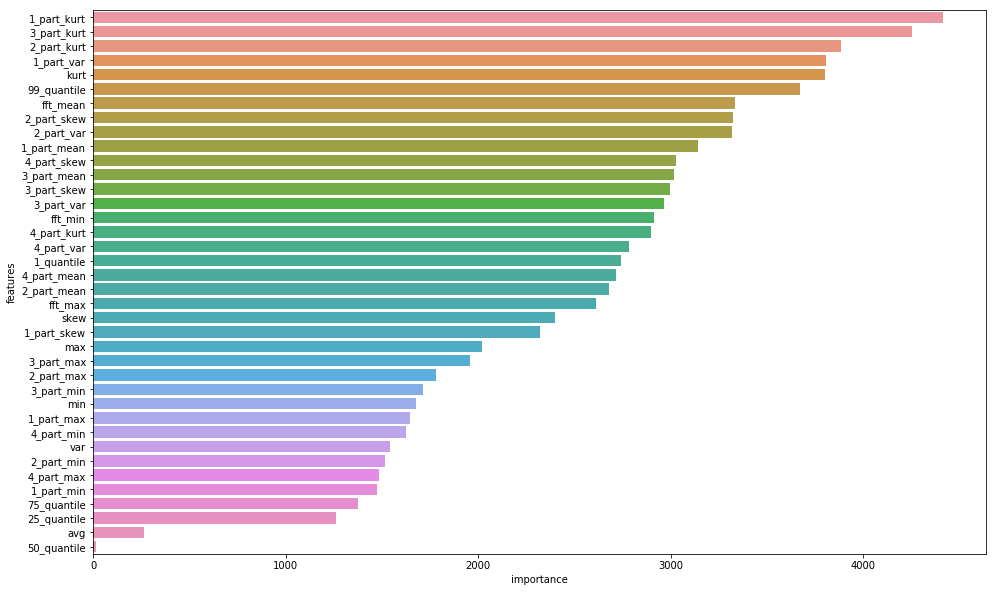

In [51]:
features_importance["importance"] = features_importance["importance"]/5
predictions["time_to_failure"] = predictions["time_to_failure"]/5

plt.figure(figsize=(16,10))
ax = sns.barplot(x="importance", y="features", data=features_importance.sort_values(by="importance",ascending=False))


In [53]:
predictions.to_csv("../submissions/submission_lgb_quantiles_new.csv",index=False)